In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

import umap
import umap.plot
import networkx as nx
import cs_umap_plot

import time
import datetime

print(datetime.datetime.now())

2022-08-01 15:20:30.042801


In [2]:
path_data = 'data/d20220201/'

# INPUTS
fn_finalSave = path_data + 'featuresAndMeta_s20220720.p'
fn_featureImp = path_data + 'featureImportance_binaryAll_s20220704'
fn_trainingResults = path_data + 'trainingResults_binary80_s20220704.p'

# OUTPUTS

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 10
plt.rcParams['figure.autolayout']=False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [3]:
# load model
with open(fn_trainingResults, "rb") as input_file:
    trainingResults = pickle.load(input_file)

currModel = trainingResults['model_rf_ovr']
trainingResults.keys()

dict_keys(['importances', 'feat2keep', 'groups', 'model_rf_ovr', 'model_rf_blind'])

In [4]:
# load features
with open(fn_finalSave, "rb") as input_file:
    dict_data = pickle.load(input_file)

dict_data.keys()

dict_keys(['df_rawFeatures_training', 'df_rawFeatures_validation', 'dict_normalizationFactors', 'df_zscoreFeatures_training', 'df_zscoreFeatures_validation', 'df_metadata', 'umap_raw', 'umap_zscore'])

In [ ]:
#dict_data['df_metadata']

In [6]:
df_allFeatures = pd.concat([dict_data['df_zscoreFeatures_training'], dict_data['df_zscoreFeatures_validation']])
print(df_allFeatures.shape)
df_relevantFeat = df_allFeatures[trainingResults['feat2keep']]
df_relevantFeat

(562, 2436)


feature,wavelet-HLH_firstorder_Mean_liver,log-sigma-3-0-mm-3D_firstorder_Median_liver,original_shape_Maximum2DDiameterRow_liver,wavelet-LHL_firstorder_Median_liver,log-sigma-5-0-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis_liver,log-sigma-4-0-mm-3D_gldm_DependenceVariance_spleen,wavelet-LLL_firstorder_90Percentile_liver,wavelet-LHL_gldm_SmallDependenceHighGrayLevelEmphasis_liver,log-sigma-1-0-mm-3D_glszm_ZoneEntropy_spleen,wavelet-HLH_glcm_Imc2_spleen,...,wavelet-LLH_gldm_SmallDependenceLowGrayLevelEmphasis_spleen,wavelet-HLL_firstorder_Mean_spleen,log-sigma-1-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_spleen,wavelet-LLH_glrlm_ShortRunLowGrayLevelEmphasis_spleen,log-sigma-3-0-mm-3D_glcm_JointAverage_spleen,log-sigma-2-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_spleen,log-sigma-3-0-mm-3D_glcm_Imc2_spleen,wavelet-HLL_glcm_ClusterShade_spleen,wavelet-LHH_gldm_LargeDependenceHighGrayLevelEmphasis_spleen,wavelet-HHH_glrlm_RunVariance_spleen
0001,0.268456,-2.64224,0.0176259,-1.24094,1.58281,0.417264,-0.807549,-0.367259,0.773938,0.526841,...,-0.524928,1.01806,5.19332,-0.517188,0.227638,3.11007,-0.579914,0.652486,1.36217,0.794562
0002,-0.22934,-1.67125,-0.472058,1.07367,1.14625,-0.962231,-1.0422,-0.66741,-0.996347,-1.47733,...,1.45623,0.667322,-0.471035,3.69897,-0.208784,0.135224,-0.890952,0.536219,-1.31644,0.428227
0004,-1.16683,0.592689,-0.0583008,0.917337,-0.90843,0.0408301,0.498473,-0.664632,-0.178218,-0.754518,...,-0.774801,-0.28865,-0.299412,0.213407,-0.892513,-0.0964884,0.236732,-0.506362,-0.749343,0.413881
0005,0.173529,0.0071895,-0.6666,0.900299,-0.671828,-0.371584,0.646022,-0.355697,-1.7721,-0.383122,...,-0.325806,0.982298,-0.633593,0.408377,-1.23885,-0.795056,-1.72975,0.604588,0.511592,-0.310932
0006,-0.816107,0.251678,0.079799,-0.905559,-1.34961,1.79193,0.695649,0.538951,0.191452,-0.476629,...,-0.635705,0.164852,-0.120722,-0.676911,0.69846,0.694349,0.549756,0.045501,0.265042,0.599587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,-0.220177,1.61159,1.18115,0.0658336,-1.22001,0.186303,0.442645,-0.0825918,-0.202065,-1.41711,...,0.160103,-0.41856,-0.59525,-0.129867,0.112639,-0.518043,0.909344,-0.181425,0.751763,-0.191555
1133,-1.53851,-0.0392161,-1.55714,-2.19969,-0.160364,1.35064,0.757783,0.906631,2.17885,-0.186328,...,0.129327,-1.44797,-0.490643,-0.391214,0.440822,-0.589546,0.761948,-0.527914,2.4558,0.348122
1135,-2.07274,0.552869,-0.996778,0.220072,-1.13145,-0.352963,-0.04134,0.252368,1.01388,-1.26184,...,0.182646,-2.16544,-0.613703,-0.318775,-0.422373,-1.06982,1.10851,-0.622701,-0.462569,0.163948
1137,0.80321,1.20509,0.140829,1.2831,-0.797986,0.333596,-0.933814,-0.940644,1.69304,-1.40715,...,-0.208007,-1.22284,-0.556952,-0.398009,1.60469,-0.458975,1.37023,-0.271141,-0.27732,0.346544


In [7]:
df_metadata = dict_data['df_metadata']
# assign 0 for healthy
df_metadata['hvpg_corrected_cs'] = df_metadata['hvpg_corrected'].fillna(0)
# assign binary grps
df_metadata['hvpg_binary'] = df_metadata['hvpg_corrected_cs'].apply(lambda x: 0 if x < 10 else 1)


In [ ]:
labels = df_metadata['hvpg_binary']
assignments = currModel.predict(df_relevantFeat)
probabilities = currModel.predict_proba(df_relevantFeat)

df_metadata['probs'] = probabilities[:,1]
df_metadata['assignment'] = assignments
df_metadata['classification_sort'] = df_metadata['hvpg_binary'] - df_metadata['assignment']
df_metadata['classification_sort1'] = df_metadata.classification_sort.map({0: "Correct", 1: "FalseNeg", -1: "FalsePos"})

#df_metadata

In [ ]:
#df_metadata

In [10]:
df_metadata['ptID'] = df_metadata.index
df_metadata['healthy_yn'] = df_metadata['ptID'].apply(lambda x: 0 if x[0]=='0' else 1)

temp = df_metadata[df_metadata['healthy_yn']==0]
print('# in cohort:')
print(len(temp))
print('of those in training set:')
print(len(temp[temp['trainTest']=='0']))
print('of those in validation set:')
print(len(temp[temp['trainTest']=='1']))


temp = df_metadata[df_metadata['healthy_yn']==1]
print('# healthy:')
print(len(temp))
print('of those in training set:')
print(len(temp[temp['trainTest']=='0']))
print('of those in validation set:')
print(len(temp[temp['trainTest']=='1']))

# in cohort:
442
of those in training set:
357
of those in validation set:
85
# healthy:
120
of those in training set:
96
of those in validation set:
24


In [ ]:
#df_metadata[df_metadata['trainTest']=='1']

In [13]:
print('# correctly predicted')
print(sum(df_metadata['classification_sort']==0))
print('# with mmHg <10mm, but classified as >=10mm')
print(sum(df_metadata['classification_sort']==-1))
print('# with mmHg >=10mm, but classified as <10mm')
print(sum(df_metadata['classification_sort']==1))

# correctly predicted
317
# with mmHg <10mm, but classified as >=10mm
137
# with mmHg >=10mm, but classified as <10mm
108


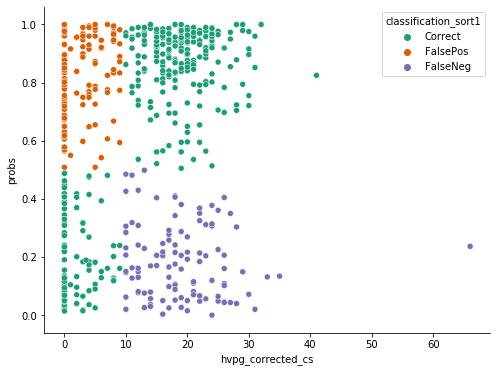

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df_metadata, x="hvpg_corrected_cs", y="probs", hue="classification_sort1", 
                palette="Dark2")

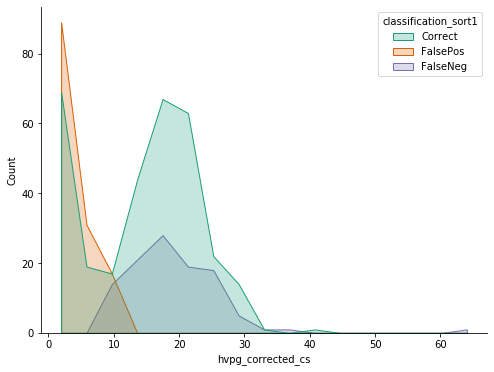

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_palette("Set3")
sns.histplot(df_metadata, x="hvpg_corrected_cs", hue="classification_sort1", element="poly", palette="Dark2")

Text(0.5, 1.0, 'classi_sort')

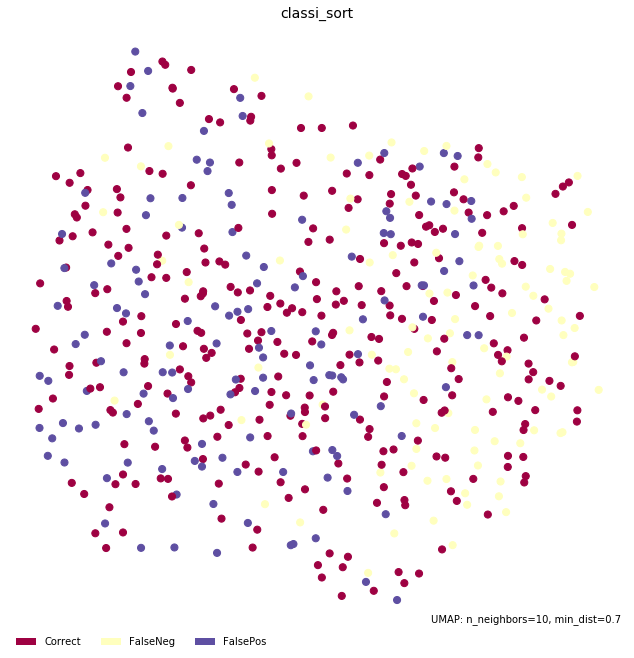

In [16]:
## play with umap parameters
# goal: somethign that separates mmHg
# goal: check if there is batch effect from CT 

fit = umap.UMAP(n_neighbors = 10,
                min_dist = 0.7)
embedding = fit.fit_transform(df_relevantFeat)
mapper = fit.fit(df_relevantFeat)

ax = cs_umap_plot.points(mapper, labels=df_metadata['classification_sort1'], point_size=50, show_legend=True)
ax.axis('off')
plt.title('classi_sort')

In [ ]:
#df_metadata[df_metadata['classification_sort']==-1]

In [18]:
trainingset = df_metadata[df_metadata['trainTest']=='0']
print('# correctly predicted')
print(sum(trainingset['classification_sort']==0))
print('# with mmHg <10mm, but classified as >=10mm')
print(sum(trainingset['classification_sort']==-1))
print('# with mmHg >=10mm, but classified as <10mm')
print(sum(trainingset['classification_sort']==1))

# correctly predicted
252
# with mmHg <10mm, but classified as >=10mm
111
# with mmHg >=10mm, but classified as <10mm
90


In [19]:
testingset = df_metadata[df_metadata['trainTest']=='1']
print('# correctly predicted')
print(sum(testingset['classification_sort']==0))
print('# with mmHg <10mm, but classified as >=10mm')
print(sum(testingset['classification_sort']==-1))
print('# with mmHg >=10mm, but classified as <10mm')
print(sum(testingset['classification_sort']==1))

# correctly predicted
65
# with mmHg <10mm, but classified as >=10mm
26
# with mmHg >=10mm, but classified as <10mm
18


In [20]:
print(datetime.datetime.now())

2022-08-01 15:20:42.684311
